<a href="https://colab.research.google.com/github/Aqvafor-AI/Using-GANs-to-Generate-Clothing-Samples/blob/main/%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_GAN%2C_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D1%86%D0%BE%D0%B2_%D0%BE%D0%B4%D0%B5%D0%B6%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

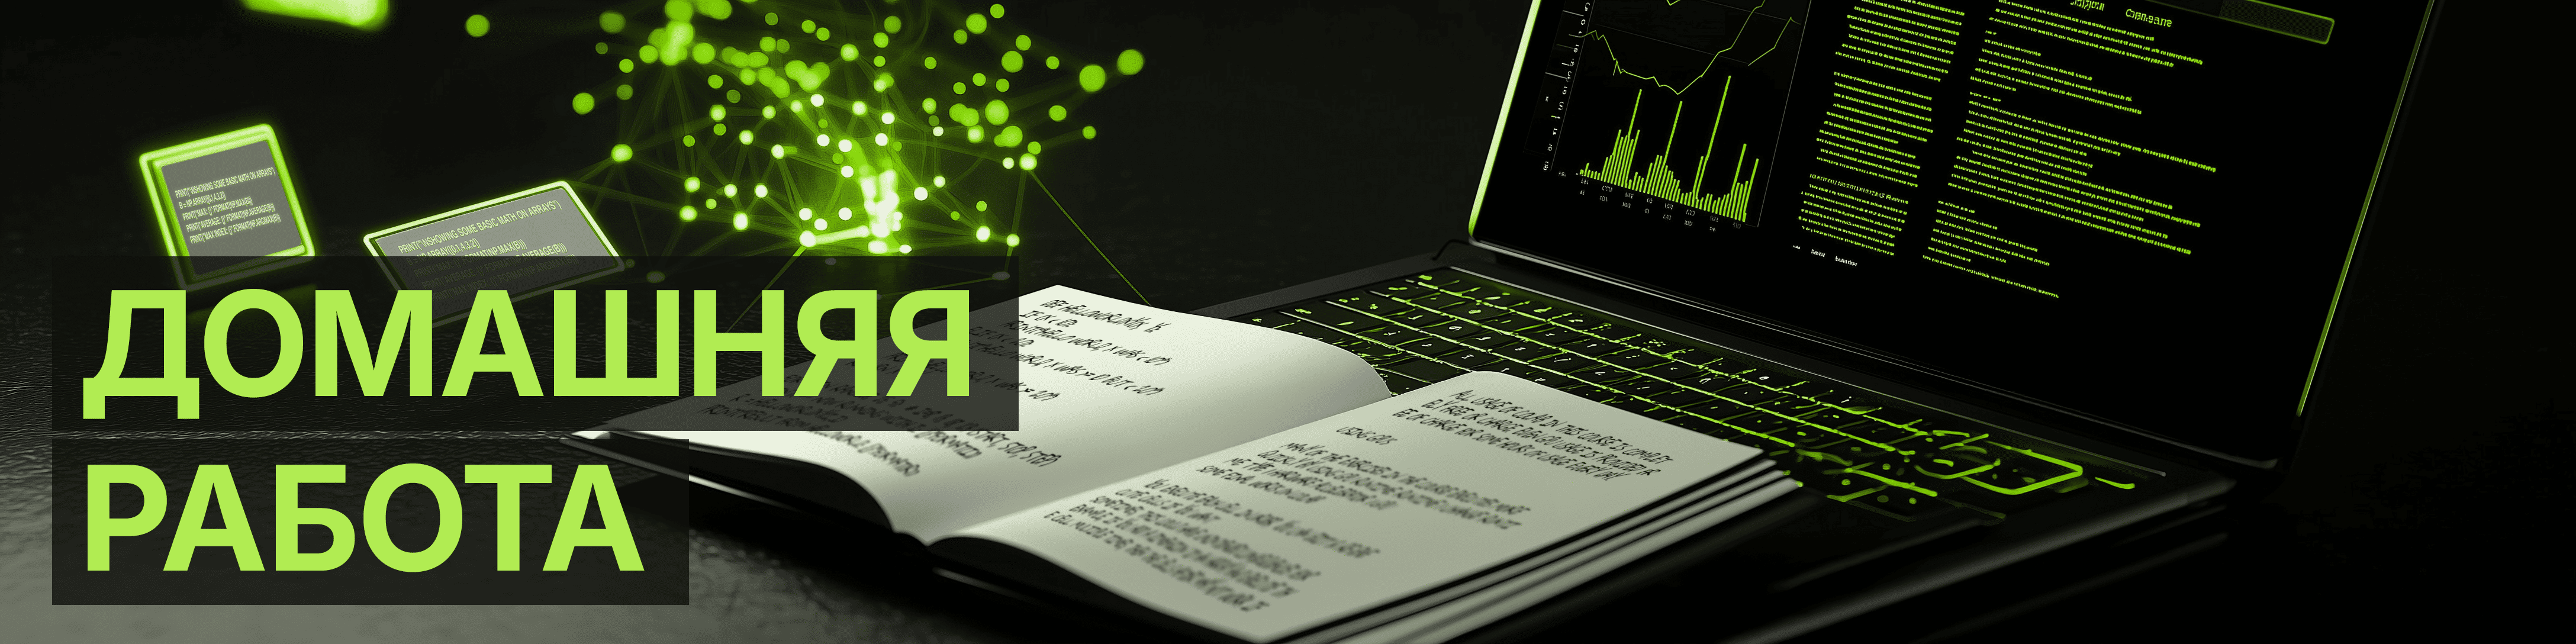

**Задание**

1. Ваша задача, используя датасет MNIST Fashion (из набора датасетов Tensorflow) научить GAN генерировать образцы одежды, соответственно.

2. Добейтесь хорошего качества генерации.

In [ ]:
# 1 Импортируем библиотеки
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
# 2 Препроцессинг и загрузка данных
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5   # Нормализация в [-1, 1]
    image = tf.expand_dims(image, axis=-1)  # [28,28] -> [28,28,1]
    return image

BATCH_SIZE = 128
LATENT_DIM = 100
BUFFER_SIZE = 60000

# Загружаем Fashion MNIST
(train_data, val_data, test_data) = tfds.load(
    "fashion_mnist",
    split=["train[10000:]", "train[:10000]", "test"],
    as_supervised=True
)

train_data = train_data.map(lambda img, lbl: preprocess(img, lbl)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.IQ0MUW_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.IQ0MUW_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# 3 Генератор
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [ ]:
# 4 Дискриминатор
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = make_generator()
discriminator = make_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 5 Определяем функцию потерь и оптимизаторы
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# 6 Обучающий цикл
EPOCHS = 100
noise_dim = LATENT_DIM
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
# 7 Визуализация сгенерированных изображений
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

Epoch 1, Generator loss: 0.8523, Discriminator loss: 1.1531


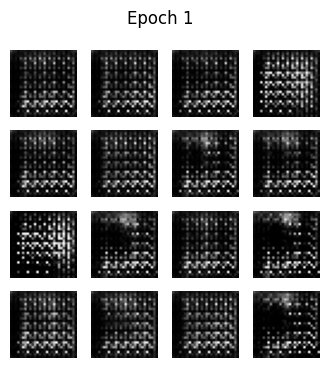

Epoch 2, Generator loss: 0.9601, Discriminator loss: 1.1313
Epoch 3, Generator loss: 0.8132, Discriminator loss: 1.3411
Epoch 4, Generator loss: 0.9102, Discriminator loss: 1.2351
Epoch 5, Generator loss: 0.8991, Discriminator loss: 1.2315


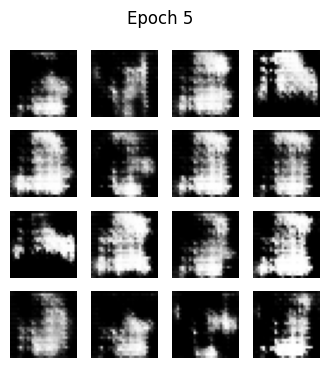

Epoch 6, Generator loss: 0.8725, Discriminator loss: 1.2501
Epoch 7, Generator loss: 0.9204, Discriminator loss: 1.2162
Epoch 8, Generator loss: 1.0778, Discriminator loss: 1.1110
Epoch 9, Generator loss: 1.0975, Discriminator loss: 1.1004
Epoch 10, Generator loss: 1.2005, Discriminator loss: 0.9832


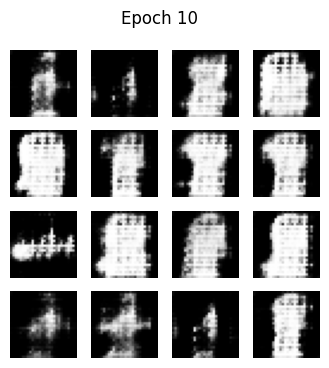

Epoch 11, Generator loss: 1.2317, Discriminator loss: 0.9749
Epoch 12, Generator loss: 1.3934, Discriminator loss: 0.8833
Epoch 13, Generator loss: 1.5709, Discriminator loss: 0.8034
Epoch 14, Generator loss: 1.6433, Discriminator loss: 0.7515
Epoch 15, Generator loss: 1.6051, Discriminator loss: 0.7964


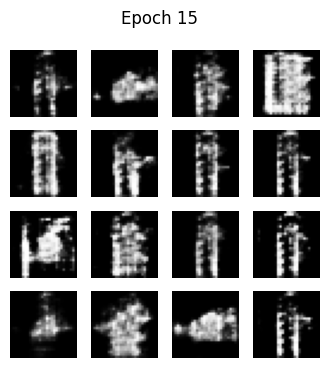

Epoch 16, Generator loss: 1.6509, Discriminator loss: 0.8051
Epoch 17, Generator loss: 1.5787, Discriminator loss: 0.8431
Epoch 18, Generator loss: 1.6221, Discriminator loss: 0.8206
Epoch 19, Generator loss: 1.4910, Discriminator loss: 0.9101
Epoch 20, Generator loss: 1.4817, Discriminator loss: 0.8968


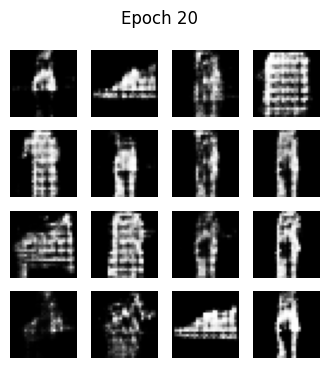

Epoch 21, Generator loss: 1.5907, Discriminator loss: 0.8573
Epoch 22, Generator loss: 1.5887, Discriminator loss: 0.8499
Epoch 23, Generator loss: 1.5311, Discriminator loss: 0.9036
Epoch 24, Generator loss: 1.4015, Discriminator loss: 0.9746
Epoch 25, Generator loss: 1.4016, Discriminator loss: 0.9334


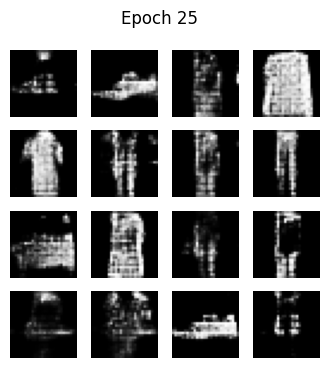

Epoch 26, Generator loss: 1.3746, Discriminator loss: 0.9587
Epoch 27, Generator loss: 1.4112, Discriminator loss: 0.9306
Epoch 28, Generator loss: 1.3694, Discriminator loss: 0.9630
Epoch 29, Generator loss: 1.3636, Discriminator loss: 0.9758
Epoch 30, Generator loss: 1.3901, Discriminator loss: 0.9582


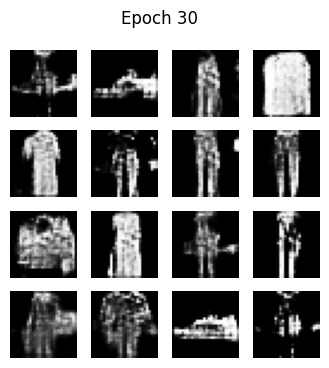

Epoch 31, Generator loss: 1.3185, Discriminator loss: 0.9877
Epoch 32, Generator loss: 1.3745, Discriminator loss: 0.9809
Epoch 33, Generator loss: 1.3959, Discriminator loss: 0.9463
Epoch 34, Generator loss: 1.4047, Discriminator loss: 0.9665
Epoch 35, Generator loss: 1.3001, Discriminator loss: 1.0116


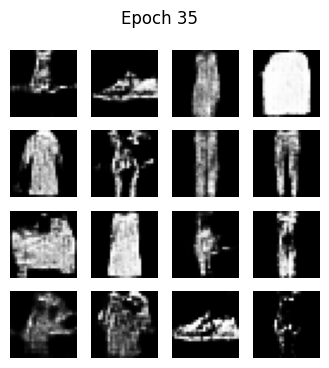

Epoch 36, Generator loss: 1.2557, Discriminator loss: 1.0373
Epoch 37, Generator loss: 1.2450, Discriminator loss: 1.0207
Epoch 38, Generator loss: 1.3344, Discriminator loss: 0.9695
Epoch 39, Generator loss: 1.2814, Discriminator loss: 1.0247
Epoch 40, Generator loss: 1.3079, Discriminator loss: 1.0043


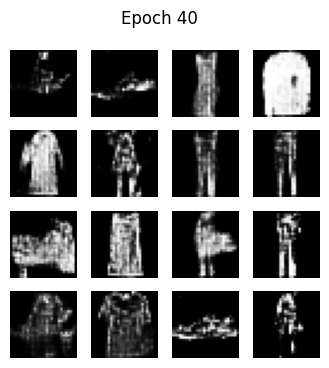

Epoch 41, Generator loss: 1.2909, Discriminator loss: 1.0154
Epoch 42, Generator loss: 1.3090, Discriminator loss: 1.0115
Epoch 43, Generator loss: 1.3050, Discriminator loss: 1.0223
Epoch 44, Generator loss: 1.2049, Discriminator loss: 1.0724
Epoch 45, Generator loss: 1.1595, Discriminator loss: 1.0980


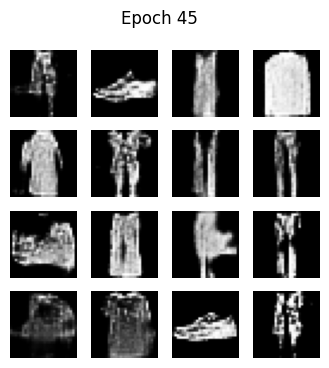

Epoch 46, Generator loss: 1.2082, Discriminator loss: 1.0542
Epoch 47, Generator loss: 1.4435, Discriminator loss: 0.9302
Epoch 48, Generator loss: 1.3231, Discriminator loss: 0.9991
Epoch 49, Generator loss: 1.2898, Discriminator loss: 1.0112
Epoch 50, Generator loss: 1.2979, Discriminator loss: 1.0189


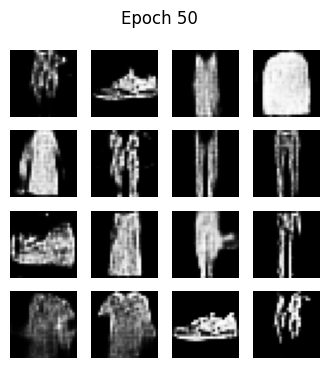

Epoch 51, Generator loss: 1.2153, Discriminator loss: 1.0770
Epoch 52, Generator loss: 1.1829, Discriminator loss: 1.0872
Epoch 53, Generator loss: 1.1511, Discriminator loss: 1.1036
Epoch 54, Generator loss: 1.1309, Discriminator loss: 1.1237
Epoch 55, Generator loss: 1.2720, Discriminator loss: 1.0318


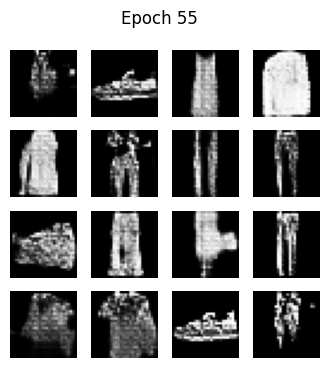

Epoch 56, Generator loss: 1.4659, Discriminator loss: 0.9296
Epoch 57, Generator loss: 1.3445, Discriminator loss: 0.9794
Epoch 58, Generator loss: 1.2673, Discriminator loss: 1.0425
Epoch 59, Generator loss: 1.1661, Discriminator loss: 1.1018
Epoch 60, Generator loss: 1.1760, Discriminator loss: 1.0834


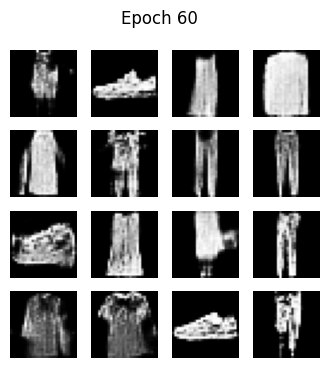

Epoch 61, Generator loss: 1.1318, Discriminator loss: 1.1125
Epoch 62, Generator loss: 1.1331, Discriminator loss: 1.1093
Epoch 63, Generator loss: 1.1189, Discriminator loss: 1.1265
Epoch 64, Generator loss: 1.1305, Discriminator loss: 1.1078
Epoch 65, Generator loss: 1.2010, Discriminator loss: 1.0600


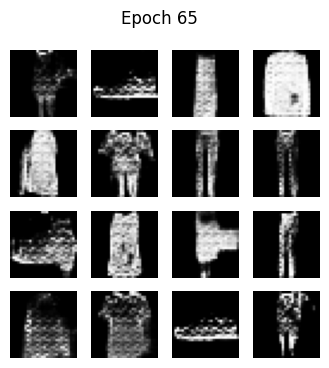

Epoch 66, Generator loss: 1.2648, Discriminator loss: 1.0379
Epoch 67, Generator loss: 1.2248, Discriminator loss: 1.0638
Epoch 68, Generator loss: 1.1397, Discriminator loss: 1.1161
Epoch 69, Generator loss: 1.0899, Discriminator loss: 1.1372
Epoch 70, Generator loss: 1.0745, Discriminator loss: 1.1501


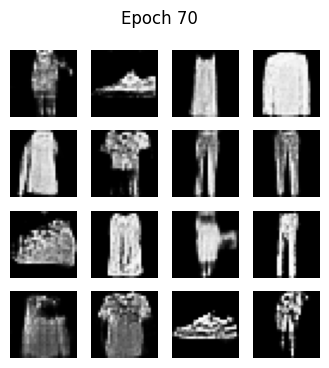

Epoch 71, Generator loss: 1.0851, Discriminator loss: 1.1486
Epoch 72, Generator loss: 1.0762, Discriminator loss: 1.1536
Epoch 73, Generator loss: 1.0552, Discriminator loss: 1.1637
Epoch 74, Generator loss: 1.0818, Discriminator loss: 1.1449
Epoch 75, Generator loss: 1.0825, Discriminator loss: 1.1420


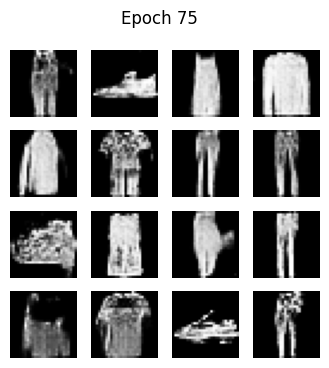

Epoch 76, Generator loss: 1.0620, Discriminator loss: 1.1665
Epoch 77, Generator loss: 1.0658, Discriminator loss: 1.1629
Epoch 78, Generator loss: 1.0491, Discriminator loss: 1.1744
Epoch 79, Generator loss: 1.0376, Discriminator loss: 1.1790
Epoch 80, Generator loss: 1.0344, Discriminator loss: 1.1810


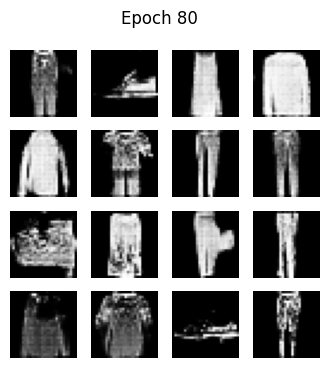

Epoch 81, Generator loss: 1.1020, Discriminator loss: 1.1469
Epoch 82, Generator loss: 1.5526, Discriminator loss: 0.8681
Epoch 83, Generator loss: 1.2690, Discriminator loss: 1.0506
Epoch 84, Generator loss: 1.1286, Discriminator loss: 1.1275
Epoch 85, Generator loss: 1.0749, Discriminator loss: 1.1594


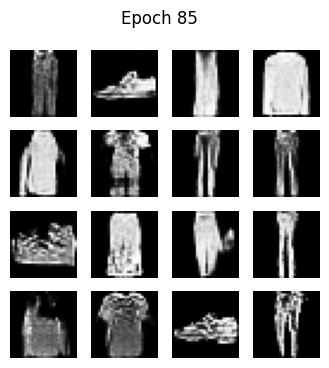

Epoch 86, Generator loss: 1.0555, Discriminator loss: 1.1596
Epoch 87, Generator loss: 1.0607, Discriminator loss: 1.1535
Epoch 88, Generator loss: 1.2404, Discriminator loss: 1.0449
Epoch 89, Generator loss: 1.2548, Discriminator loss: 1.0361
Epoch 90, Generator loss: 1.1231, Discriminator loss: 1.1439


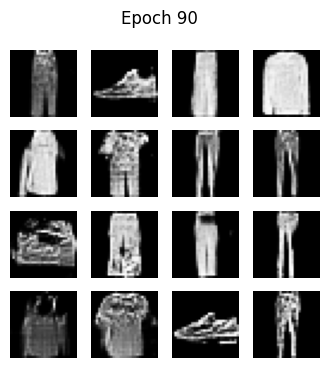

Epoch 91, Generator loss: 1.0635, Discriminator loss: 1.1604
Epoch 92, Generator loss: 1.0336, Discriminator loss: 1.1830
Epoch 93, Generator loss: 1.0458, Discriminator loss: 1.1739
Epoch 94, Generator loss: 1.0415, Discriminator loss: 1.1799
Epoch 95, Generator loss: 1.0367, Discriminator loss: 1.1773


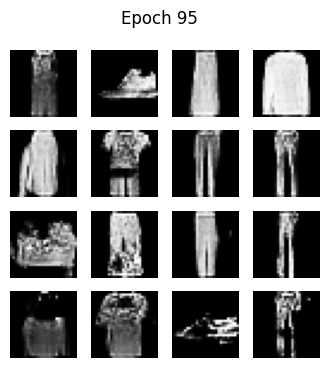

Epoch 96, Generator loss: 1.0213, Discriminator loss: 1.1919
Epoch 97, Generator loss: 1.0312, Discriminator loss: 1.1792
Epoch 98, Generator loss: 1.0246, Discriminator loss: 1.1905
Epoch 99, Generator loss: 1.0215, Discriminator loss: 1.1914
Epoch 100, Generator loss: 1.0133, Discriminator loss: 1.2008


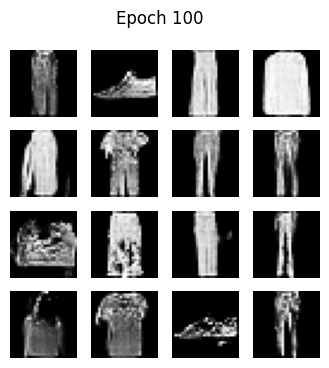

In [ ]:
# 8 Основной цикл обучения + сохранение потерь
G_losses, D_losses = [], []
for epoch in range(1, EPOCHS + 1):
    gen_loss_avg, disc_loss_avg, num_batches = 0, 0, 0
    for image_batch in train_data:
        g_loss, d_loss = train_step(image_batch)
        gen_loss_avg += g_loss
        disc_loss_avg += d_loss
        num_batches += 1
    G_losses.append(float(gen_loss_avg) / num_batches)
    D_losses.append(float(disc_loss_avg) / num_batches)
    print(f'Epoch {epoch}, Generator loss: {G_losses[-1]:.4f}, Discriminator loss: {D_losses[-1]:.4f}')
    if epoch % 5 == 0 or epoch == 1 or epoch == EPOCHS:
        generate_and_save_images(generator, epoch, seed)

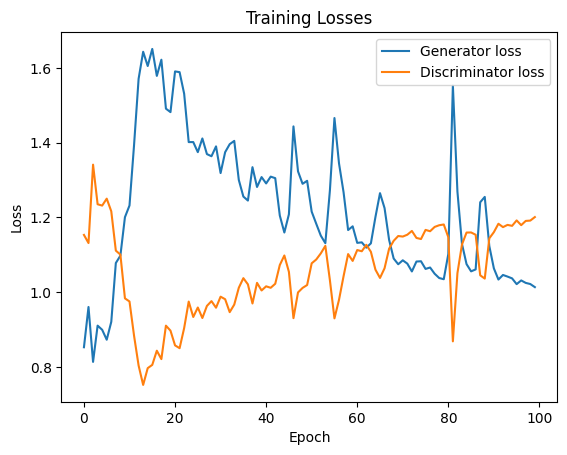

In [ ]:
# 9. График функции потерь
plt.plot(G_losses, label='Generator loss')
plt.plot(D_losses, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()